Tried training a model with resnet18

In [1]:
# Import all needed libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision import datasets, transforms, models
# These last two are used to save info about how the training progressed
import pickle
import datetime

In [2]:
data_dir = 'microscope_images'
# Make sure you are running the code from the folder that contains data_dir, or it won't work
num_train = 10
num_test = 10

# Define transforms for the training data and testing data
resnet_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Load the images from the image folder
traindata = datasets.ImageFolder(data_dir + '/train', transform=resnet_transforms)
testdata = datasets.ImageFolder(data_dir + '/test', transform=resnet_transforms)

# Load from the training and test sets
trainloader = torch.utils.data.DataLoader(traindata, batch_size=num_train, shuffle=True)
testloader = torch.utils.data.DataLoader(testdata, batch_size=num_test, shuffle=True)
# Check if cuda is available, and set pytorch to run on GPU or CPU as appropriate
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Cuda available, running on GPU')
else:
    device = torch.device("cpu")
    print('Cuda is not available, running on CPU')
    # Give the user a message so they know what is going on

# Get the pre-trained model, here it is resnet18
model = models.resnet18(pretrained=True)
#print(model) 
# Printing the model shows some of the internal layers, not expected to
# understand these but neat to see

# Freeze the pre-trained layers, no need to update featue detection
for param in model.parameters():
    param.requires_grad = False

# Get the number of features the model expects in the final fully connected layer, this is different
# in different models
num_ftrs = model.fc.in_features

# Re-define the final fully connected layer (model.fc, fc = fully connected)
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512), # input features converts to 512 features 
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 # The next line needs to be modified for the number of classes
                                 # in the data set. For the microscope images I currently have 
                                 # five classes, so there are 5 outputs
                                 nn.Linear(512, 5), # 512 inputs to 5 outputs
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)


# Train the network
epochs = 2
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses, accuracy_tracker = [], [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            accuracy_tracker.append(accuracy/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

# Save the model
torch.save(model, 'autofocus_resnet18.pth')

Cuda is not available, running on CPU
Epoch 1/2.. Train loss: 2.068.. Test loss: 1.650.. Test accuracy: 0.326
Epoch 1/2.. Train loss: 1.714.. Test loss: 1.720.. Test accuracy: 0.324
Epoch 1/2.. Train loss: 1.664.. Test loss: 1.442.. Test accuracy: 0.387
Epoch 1/2.. Train loss: 1.429.. Test loss: 1.436.. Test accuracy: 0.370
Epoch 1/2.. Train loss: 1.627.. Test loss: 1.475.. Test accuracy: 0.326
Epoch 1/2.. Train loss: 1.487.. Test loss: 1.435.. Test accuracy: 0.377
Epoch 1/2.. Train loss: 1.484.. Test loss: 1.442.. Test accuracy: 0.382
Epoch 1/2.. Train loss: 1.362.. Test loss: 1.432.. Test accuracy: 0.387
Epoch 2/2.. Train loss: 1.411.. Test loss: 1.425.. Test accuracy: 0.387
Epoch 2/2.. Train loss: 1.376.. Test loss: 1.478.. Test accuracy: 0.324
Epoch 2/2.. Train loss: 1.439.. Test loss: 1.414.. Test accuracy: 0.386
Epoch 2/2.. Train loss: 1.503.. Test loss: 1.427.. Test accuracy: 0.392
Epoch 2/2.. Train loss: 1.435.. Test loss: 1.416.. Test accuracy: 0.366
Epoch 2/2.. Train loss: 1.

In [3]:
# Save the information about how training went
# Get a unique date and time to id this training round
now = datetime.datetime.now()
time_string = (':').join([str(now.hour), str(now.minute)]) 
date_string = ('-').join([str(now.month), str(now.day), str(now.year)])
file_name = ('_').join(['resnet18_training', date_string, time_string])

fileObject = open(file_name, 'wb')
training_data = [train_losses, test_losses, accuracy_tracker]
pickle.dump(training_data, fileObject)
fileObject.close
fileObject.close()

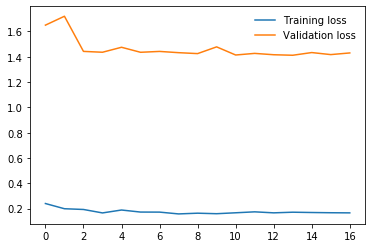

In [6]:
%matplotlib inline
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

These training results are in line with what I observed running Resnet18 on the GPU - training plateaus and the model never really improves past just under 40% accuracy.